# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

Загрузим и изучим исходные данные:

In [ ]:
data = pd.read_csv('/datasets/autos.csv')

In [ ]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Можно заметить, что в данных присутствуют пропущенные значения и категориальные признаки, которые необходимо обработать.

Также удалим неинформативные для построения модели признаки:

In [ ]:
data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis = 1, inplace=True)

Проверим датасет на наличие дубликатов и удалим найденные:

In [ ]:
data.duplicated().sum()

27543

In [ ]:
data = data.drop_duplicates().reset_index(drop=True)

In [ ]:
data.duplicated().sum()

0

Проверим количество пропусков в каждом из столбцов:

In [ ]:
data.isna().sum()

Price                    0
VehicleType          35249
RegistrationYear         0
Gearbox              17578
Power                    0
Model                18532
Kilometer                0
RegistrationMonth        0
FuelType             31122
Brand                    0
Repaired             66427
dtype: int64

Так как восстановить пропущенные значения не представляется возможным, заменим пропуски на значения "unknown":

In [ ]:
def nan_fill(column):
    column.fillna('unknown', inplace=True)
    return column

In [ ]:
nan_fill(data['VehicleType'])
nan_fill(data['Gearbox'])
nan_fill(data['Model'])
nan_fill(data['FuelType'])
nan_fill(data['Repaired'])

0         unknown
1             yes
2         unknown
3              no
4              no
           ...   
326821        yes
326822    unknown
326823         no
326824         no
326825    unknown
Name: Repaired, Length: 326826, dtype: object

In [ ]:
data.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
dtype: int64

Изучим статистические характеристики числовых данных:

In [ ]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,326826.000000,326826.000000,326826.000000,326826.000000,326826.000000
mean,4403.747330,2004.230985,110.244705,128144.073605,5.696239
std,4518.209808,91.120018,195.886373,37947.663920,3.724122
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1000.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6350.000000,2008.000000,141.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


Можно заметить аномально низкие и аномально высокие значения в таких столбцах, как Price, RegistrationYear, Power и RegistrationMonth. Посмотрим на них подробнее:

Изучим распределение признака Price с помощью диаграммы размаха ("ящик с усами"):

<AxesSubplot:>

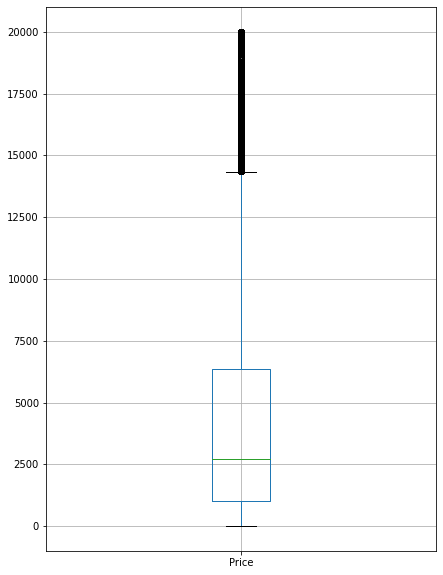

In [ ]:
data.boxplot(column='Price', figsize=(7, 10))

Судя по полученному графику, в данном признаке присутствует довольно большое количество аномальные объектов по цене выше ~ 14000 евро. Также, стоит установить нижнюю границу цены, например в 300 евро, предполагая, что за меньшую стоимость продажа автомобиля просто невозможна.

In [ ]:
data = data.loc[data['Price'] > 300]

Посмотрим на некоторые аномально высокие значения:

In [ ]:
data.loc[data['Price'] > 19000]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
172,19750,convertible,2006,manual,305,mustang,50000,7,petrol,ford,no
484,19900,bus,2009,manual,150,viano,90000,5,gasoline,mercedes_benz,no
1360,19850,sedan,2013,auto,150,golf,60000,6,gasoline,volkswagen,no
1514,20000,sedan,2010,auto,239,a6,150000,5,gasoline,audi,no
1585,20000,sedan,2014,auto,184,leon,40000,4,gasoline,seat,no
...,...,...,...,...,...,...,...,...,...,...,...
325812,19500,bus,1970,auto,69,transporter,30000,11,petrol,volkswagen,unknown
326160,19950,wagon,2009,manual,265,other,125000,1,petrol,audi,no
326550,20000,coupe,2006,auto,476,other,125000,7,petrol,mercedes_benz,no
326666,19990,small,2014,auto,185,a1,10000,2,petrol,audi,no


In [ ]:
data['Price'].describe()

count    303025.000000
mean       4740.724349
std        4522.974642
min         301.000000
25%        1350.000000
50%        3000.000000
75%        6800.000000
max       20000.000000
Name: Price, dtype: float64

В признаке RegistrationYear можно увидеть такие аномальные значения, как, например, год регистрации 1000 или 9999. Ограничим год выпуска автомобилей с 1950 по 2023 (текущий год):

In [ ]:
data = data.loc[(data['RegistrationYear'] > 1950) & (data['RegistrationYear'] < 2023)]

In [ ]:
data['RegistrationYear'].describe()

count    302833.000000
mean       2003.361883
std           7.218085
min        1951.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: RegistrationYear, dtype: float64

Также мощность автомобиля не может быть меньше 5 и больше 2000 л. с.

In [ ]:
data = data.loc[(data['Power'] > 5) & (data['Power'] < 1000)]

In [ ]:
data['Power'].describe()

count    273513.000000
mean        121.637034
std          54.519528
min           6.000000
25%          80.000000
50%         114.000000
75%         150.000000
max         999.000000
Name: Power, dtype: float64

In [ ]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,273513.000000,273513.000000,273513.000000,273513.000000,273513.000000
mean,4948.967658,2003.437142,121.637034,128166.138355,5.989086
std,4587.012442,6.910587,54.519528,36768.765270,3.584865
min,301.000000,1951.000000,6.000000,5000.000000,0.000000
25%,1450.000000,1999.000000,80.000000,125000.000000,3.000000
50%,3300.000000,2004.000000,114.000000,150000.000000,6.000000
75%,7000.000000,2008.000000,150.000000,150000.000000,9.000000
max,20000.000000,2019.000000,999.000000,150000.000000,12.000000


## Обучение моделей

Перейдем к обучению моделей.
Для начала разделим выборку на обучающую, валидационную и тестовую:

In [ ]:
random_state = 12345

In [ ]:
features = data.drop('Price', axis=1)
target = data['Price']

print(features.shape)
print(target.shape)

(273513, 10)
(273513,)


In [ ]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target,
                                                                              test_size=0.2,
                                                                              random_state=12345)
features_test, features_valid, target_test, target_valid = train_test_split(features_valid,
                                                                            target_valid,
                                                                            test_size=0.25,
                                                                            random_state=12345)

print(features_train.shape)
print(target_train.shape)

print(features_valid.shape)
print(target_valid.shape)

print(features_test.shape)
print(target_test.shape)

(218810, 10)
(218810,)
(13676, 10)
(13676,)
(41027, 10)
(41027,)


Закодируем категориальные признаки и также разделим их на три выборки:

In [ ]:
data_ohe = pd.get_dummies(data, drop_first=True)

features_ohe = data_ohe.drop('Price', axis=1)
target_ohe = data_ohe['Price']

print(features_ohe.shape)
print(target_ohe.shape)

(273513, 311)
(273513,)


In [ ]:
features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features_ohe, target_ohe,
                                                                                              test_size=0.2,
                                                                                              random_state=12345)
features_test_ohe, features_valid_ohe, target_test_ohe, target_valid_ohe = train_test_split(features_valid_ohe,
                                                                                            target_valid_ohe,
                                                                                            test_size=0.25,
                                                                                            random_state=12345)

print(features_train_ohe.shape)
print(target_train_ohe.shape)

print(features_valid_ohe.shape)
print(target_valid_ohe.shape)

print(features_test_ohe.shape)
print(target_test_ohe.shape)

(218810, 311)
(218810,)
(13676, 311)
(13676,)
(41027, 311)
(41027,)


В данном проекте будет рассмотренно 3 модели: Случайный лес, CatBoost и LightGBM. Подберем лучшие гиперпараметры для каждой из моделей:

In [ ]:
%%time

best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 13, 1):
    for depth in range (1, 5, 2):
        model = RandomForestRegressor(random_state=random_state, n_estimators=est, max_depth=depth)
        model.fit(features_train_ohe, target_train_ohe)
        predictions_valid = model.predict(features_valid_ohe)
        result = mean_squared_error(target_valid_ohe, predictions_valid) ** 0.5
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print('RMSE лучшей модели:', best_result)
print('Количество деревьев:', best_est)
print('Максимальная глубина:', best_depth)

RMSE лучшей модели: 3813.5266630194533
Количество деревьев: 12
Максимальная глубина: 1
CPU times: user 44.1 s, sys: 1.5 s, total: 45.6 s
Wall time: 45.6 s


In [ ]:
%%time

model = CatBoostRegressor(loss_function='RMSE', random_state=random_state)

parameters = {
    'depth':  range (9, 13, 2),
    'learning_rate': [0.1],
    'iterations': [100, 200]
}
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

grid_cb = GridSearchCV(model, parameters, verbose=True, refit=False)
grid_cb.fit(features_train, target_train, cat_features=cat_features, verbose=10)

grid_cb.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0:	learn: 4253.8088696	total: 181ms	remaining: 17.9s
10:	learn: 2555.8235279	total: 1.29s	remaining: 10.4s
20:	learn: 2035.3429010	total: 2.36s	remaining: 8.86s
30:	learn: 1866.5592567	total: 3.41s	remaining: 7.59s
40:	learn: 1801.7657110	total: 4.5s	remaining: 6.48s
50:	learn: 1760.9303881	total: 5.55s	remaining: 5.33s
60:	learn: 1731.4983075	total: 6.61s	remaining: 4.22s
70:	learn: 1711.9358681	total: 7.72s	remaining: 3.15s
80:	learn: 1694.5457149	total: 8.8s	remaining: 2.06s
90:	learn: 1678.1603089	total: 9.87s	remaining: 976ms
99:	learn: 1663.0126751	total: 10.9s	remaining: 0us
0:	learn: 4271.9082330	total: 116ms	remaining: 11.4s
10:	learn: 2572.6270979	total: 1.24s	remaining: 9.99s
20:	learn: 2045.2058065	total: 2.31s	remaining: 8.68s
30:	learn: 1866.5491546	total: 3.37s	remaining: 7.5s
40:	learn: 1797.7768321	total: 4.45s	remaining: 6.41s
50:	learn: 1763.8171861	total: 5.57s	remaining: 5.35s
60:	learn: 1730.4115293	total

{'depth': 11, 'iterations': 200, 'learning_rate': 0.1}

In [ ]:
%%time

model = LGBMRegressor(objective='regression', metric='rmse', random_state=random_state)

parameters = {
    'num_leaves': [150, 200],
    'learning_rate': [0.1],
    'n_estimators': [200, 400]
}

grid_lgb = GridSearchCV(model, parameters, n_jobs=-1, refit=False)
grid_lgb.fit(features_train_ohe, target_train_ohe, verbose=10)

grid_lgb.best_params_

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. 

CPU times: user 11min 48s, sys: 9.38 s, total: 11min 57s
Wall time: 12min 2s


{'learning_rate': 0.1, 'n_estimators': 400, 'num_leaves': 150}

## Анализ моделей

Проанализируйте время обучения, время предсказания и качество моделей.

Случайный лес:

In [ ]:
%%time

model_rf = RandomForestRegressor(max_depth=best_depth, n_estimators=best_est, random_state=random_state)
model_rf.fit(features_train_ohe, target_train_ohe)

CPU times: user 3.37 s, sys: 208 ms, total: 3.58 s
Wall time: 3.58 s


RandomForestRegressor(max_depth=1, n_estimators=12, random_state=12345)

In [ ]:
%%time

pred_rf = model_rf.predict(features_valid_ohe)

CPU times: user 26.1 ms, sys: 7.41 ms, total: 33.5 ms
Wall time: 31.3 ms


In [ ]:
rmse_rf = mean_squared_error(target_valid_ohe, pred_rf) ** 0.5
print(rmse_rf)

3813.5266630194533


CatBoost:

In [ ]:
%%time

model_cb = CatBoostRegressor(random_state=random_state, loss_function='RMSE', **grid_cb.best_params_)
model_cb.fit(features_train, target_train, cat_features=cat_features, verbose=10)

0:	learn: 4244.0599153	total: 736ms	remaining: 2m 26s
10:	learn: 2429.4385906	total: 7.41s	remaining: 2m 7s
20:	learn: 1928.4788039	total: 13.6s	remaining: 1m 56s
30:	learn: 1767.8484256	total: 20.2s	remaining: 1m 50s
40:	learn: 1703.7142990	total: 26.4s	remaining: 1m 42s
50:	learn: 1668.8691263	total: 32.2s	remaining: 1m 33s
60:	learn: 1643.9107040	total: 37.9s	remaining: 1m 26s
70:	learn: 1621.5562727	total: 43.9s	remaining: 1m 19s
80:	learn: 1606.1447896	total: 50s	remaining: 1m 13s
90:	learn: 1592.8139219	total: 56.4s	remaining: 1m 7s
100:	learn: 1582.2562415	total: 1m 3s	remaining: 1m 1s
110:	learn: 1570.2105949	total: 1m 9s	remaining: 55.9s
120:	learn: 1558.8302477	total: 1m 15s	remaining: 49.6s
130:	learn: 1550.3282643	total: 1m 22s	remaining: 43.3s
140:	learn: 1539.4579458	total: 1m 28s	remaining: 37s
150:	learn: 1531.4140837	total: 1m 35s	remaining: 30.9s
160:	learn: 1522.4618037	total: 1m 41s	remaining: 24.6s
170:	learn: 1513.3307605	total: 1m 47s	remaining: 18.3s
180:	learn:

In [ ]:
%%time

pred_cb = model_cb.predict(features_valid)

CPU times: user 63.8 ms, sys: 64 µs, total: 63.9 ms
Wall time: 62 ms


In [ ]:
rmse_cb = mean_squared_error(target_valid, pred_cb) ** 0.5
print(rmse_cb)

1600.064118374487


LightGBM:

In [ ]:
%%time

model_lgbmr = LGBMRegressor(random_state=random_state, **grid_lgb.best_params_, n_jobs=-1)
model_lgbmr.fit(features_train_ohe, target_train_ohe)

CPU times: user 40.4 s, sys: 491 ms, total: 40.9 s
Wall time: 41.1 s


LGBMRegressor(n_estimators=400, num_leaves=150, random_state=12345)

In [ ]:
%%time

pred_lgbmr = model_lgbmr.predict(features_valid_ohe)

CPU times: user 1.08 s, sys: 16.7 ms, total: 1.1 s
Wall time: 1.07 s


In [ ]:
rmse_lgbmr = mean_squared_error(target_valid_ohe, pred_lgbmr) ** 0.5
print(rmse_lgbmr)

1560.1228002837054


### Выбор лучшей модели

Оценка полученных моделей была проведена на основе критериев, выбранных заказчиком изначально:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

В результате проведенного исследования хорошее качество показала модель CatBoost с ошибкой прогноза RMSE равной 1600 и временем предсказания - 62 мс. Однако, время обучения данной модели оставляет желать лучшего (2 мин).

Худший же результат качества показала модель Случайного леса (rmse = 3813.5), что не соответствует заданному пороговому значению в 2500. В то же время, данная модель показала одни из лучших результатов по времени обучения (3 сек) и прогноза (31 мс).

Оценивая все факторы в совокупности, для дальнейшей работы была выбрана модель LightGBM с высоким качеством (rmse = 1560) и быстрым обучением (41 сек) и прогнозом (1 сек).

В заключпение, проверим качество работы выбранной модели на тестовой выборке:

In [ ]:
%%time

pred_lgbmr = model_lgbmr.predict(features_test_ohe)
rmse_lgbmr = mean_squared_error(target_test_ohe, pred_lgbmr) ** 0.5
print(rmse_lgbmr)

1550.7338354009116
CPU times: user 3.18 s, sys: 42.8 ms, total: 3.22 s
Wall time: 3.17 s


Выбранная модель соответствует критериям при проверке на тестовой выборке.